##Implement an End to End CNN Model for Image Classification Task.

Task 1: Data Understanding and Visualization:

In [20]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report

In [21]:
import google.colab
google.colab.drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
train_dir = '/content/drive/MyDrive/6CS012 AI & ML/FruitinAmazon/FruitinAmazon/train'
test_dir = '/content/drive/MyDrive/6CS012 AI & ML/FruitinAmazon/FruitinAmazon/test'

Number of classes: 6
Class names: ['pupunha', 'acai', 'graviola', 'tucuma', 'cupuacu', 'guarana']


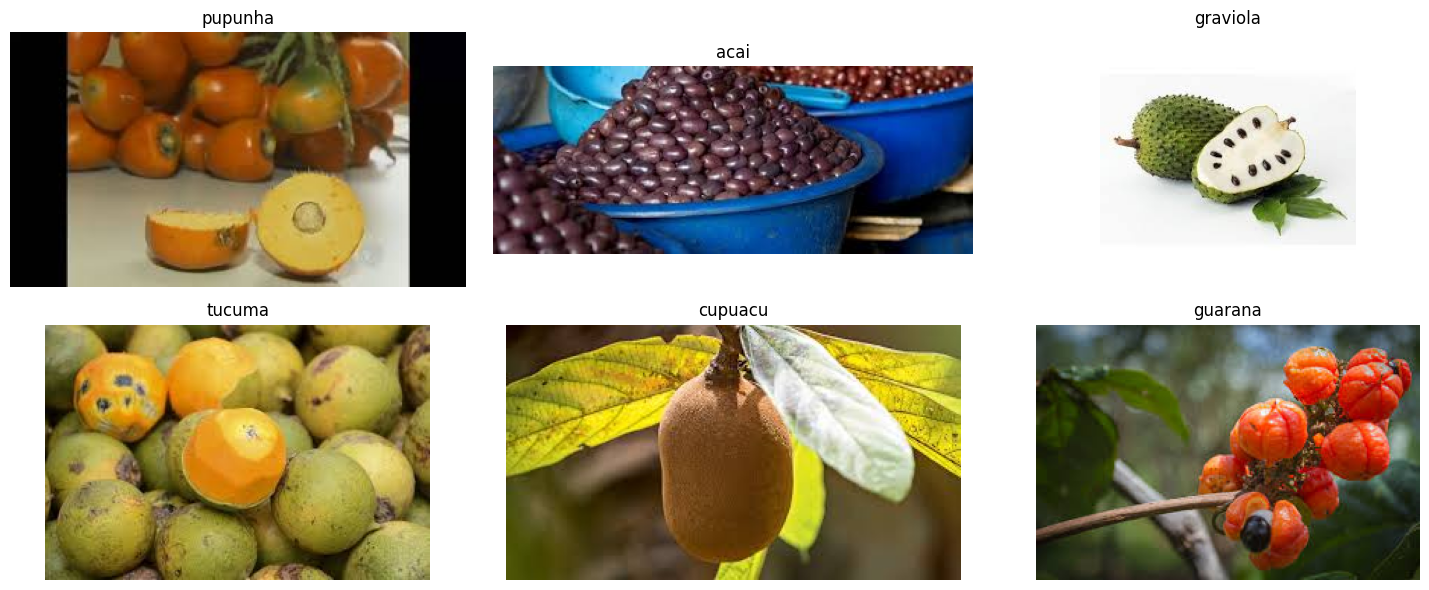

In [23]:
class_dirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
class_names = class_dirs
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

# Select one random image from each class
images = []
for class_dir in class_dirs:
    class_path = os.path.join(train_dir, class_dir)
    image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    if image_files:
        random_image = random.choice(image_files)
        image_path = os.path.join(class_path, random_image)
        images.append(image_path)

columns = (num_classes + 1) // 2
fig, axes = plt.subplots(2, columns, figsize=(15, 6))
axes = axes.flatten()

# Plot each image
for i, image_path in enumerate(images):
    img = Image.open(image_path)
    axes[i].imshow(img)
    axes[i].set_title(class_names[i])
    axes[i].axis('off')

# Hide any unused axes if num_classes is odd
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Check for Corrupted Image

In [24]:
def check_and_remove_corrupted_images(directory):
    corrupted_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(root, file)
                try:
                    img = Image.open(image_path)
                    img.verify()  # Verify the image integrity
                except (IOError, SyntaxError) as e:
                    print(f"Removed corrupted image: {image_path}")
                    os.remove(image_path)
                    corrupted_images.append(image_path)
    if not corrupted_images:
        print("No corrupted images found.")
    else:
        print(f"Total corrupted images removed: {len(corrupted_images)}")

# Run the check on the train directory
check_and_remove_corrupted_images(train_dir)

No corrupted images found.


Task 2: Loading and Preprocessing Image Data in keras:

In [26]:
# Define image size and batch size
img_height = 128
img_width = 128
batch_size = 16

# Load training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    label_mode='categorical',
    seed=123
)

# Load test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
)

# Verify class names and number of classes
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")


# Applying normalization to scale pixel values to [0,1]
rescale = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
test_ds = test_ds.map(lambda x, y: (rescale(x), y))




Found 90 files belonging to 6 classes.
Found 30 files belonging to 6 classes.
Class names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']
Number of classes: 6


Task 3 - Implement a CNN:

Convolutional Architecture:

In [27]:
model = keras.Sequential([
    # Convolutional Layer 1
    layers.Conv2D(32, (3, 3), padding='same', strides=1, activation='relu',
                  input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2), strides=2),
    # Convolutional Layer 2
    layers.Conv2D(32, (3, 3), padding='same', strides=1, activation='relu'),
    layers.MaxPooling2D((2, 2), strides=2),
    # Fully Connected Layers
    layers.Flatten(),
    layers.Dense(64, activation='relu'),  # First hidden layer
    layers.Dense(128, activation='relu'),   # Second hidden layer
    layers.Dense(num_classes, activation='softmax')  # Output layer
])

# Display model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

Task 4: Compile the Model

In [28]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [29]:
# Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    train_ds,
    epochs=250,
    validation_data=test_ds,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.1780 - loss: 2.0358

6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.1748 - loss: 2.0372 - val_accuracy: 0.3333 - val_loss: 1.8099
Epoch 2/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.3384 - loss: 1.6986

6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 681ms/step - accuracy: 0.3361 - loss: 1.7009 - val_accuracy: 0.4667 - val_loss: 1.5947
Epoch 3/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 492ms/step - accuracy: 0.3909 - loss: 1.5865 - val_accuracy: 0.4333 - val_loss: 1.4337
Epoch 4/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 301ms/step - accuracy: 0.5397 - loss: 1.2996 - val_accuracy: 0.4333 - val_loss: 1.2766
Epoch 5/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.6207 - loss: 1.0424

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step - accuracy: 0.6209 - loss: 1.0414 - val_accuracy: 0.6333 - val_loss: 1.0238
Epoch 6/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 540ms/step - accuracy: 0.7701 - loss: 0.6949 - val_accuracy: 0.6333 - val_loss: 1.0121
Epoch 7/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 294ms/step - accuracy: 0.8813 - loss: 0.5697 - val_accuracy: 0.4000 - val_loss: 1.5852
Epoch 8/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 288ms/step - accuracy: 0.8558 - loss: 0.4600 - val_accuracy: 0.5667 - val_loss: 1.2437
Epoch 9/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - accuracy: 0.9170 - loss: 0.2937 - val_accuracy: 0.5333 - val_loss: 1.3076
Epoch 10/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step - accuracy: 0.9522 - loss: 0.1537 - val_accuracy: 0.5667 - val_loss: 1.1884
Epoch 11/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 663ms/step - accuracy: 0.9559 - loss: 0.1699 - val_accuracy: 0.6333 - val_loss: 0.7842
Epoch 12/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9335 - loss: 0.1481

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 370ms/step - accuracy: 0.9382 - loss: 0.1413 - val_accuracy: 0.7000 - val_loss: 1.0915
Epoch 13/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 500ms/step - accuracy: 1.0000 - loss: 0.0537 - val_accuracy: 0.6000 - val_loss: 1.4582
Epoch 14/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 374ms/step - accuracy: 1.0000 - loss: 0.0304 - val_accuracy: 0.6667 - val_loss: 0.8700
Epoch 15/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 595ms/step - accuracy: 1.0000 - loss: 0.0099 - val_accuracy: 0.6333 - val_loss: 0.9529
Epoch 16/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 294ms/step - accuracy: 1.0000 - loss: 0.0094 - val_accuracy: 0.7000 - val_loss: 0.9388
Epoch 17/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 1.0000 - loss: 0.0039

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 324ms/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 0.7667 - val_loss: 1.0143
Epoch 18/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.7667 - val_loss: 1.1105
Epoch 19/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 726ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.7667 - val_loss: 1.1840
Epoch 20/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 354ms/step - accuracy: 1.0000 - loss: 9.8548e-04 - val_accuracy: 0.7333 - val_loss: 1.2146
Epoch 21/250
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 302ms/step - accuracy: 1.0000 - loss: 9.3768e-04 - val_accuracy: 0.7333 - val_loss: 1.2227


Task 5: Evaluate the Model

In [30]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6306 - loss: 0.8029
Test accuracy: 0.6333
Test loss: 0.7842


Task 6: Save and Load the Model

In [31]:
model.save('SachinGyawali_w5.h5')

In [32]:
loaded_model = tf.keras.models.load_model('SachinGyawali_w5.h5')
loaded_test_loss, loaded_test_acc = loaded_model.evaluate(test_ds)
print(f"Loaded model test accuracy: {loaded_test_acc:.4f}")
print(f"Loaded model test loss: {loaded_test_loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.6306 - loss: 0.8029
Loaded model test accuracy: 0.6333
Loaded model test loss: 0.7842


Task 7: Predictions and Classification Report

In [34]:
loaded_model = keras.models.load_model('SachinGyawali_w5.h5')
print("Model loaded for predictions")

# Collect all test images and labels
all_images = []
all_labels = []
for images, labels in test_ds:
    all_images.append(images.numpy())
    all_labels.append(labels.numpy())

# Concatenate batches into single arrays
test_images = np.concatenate(all_images, axis=0)  # Shape: (30, 128, 128, 3)
test_labels_onehot = np.concatenate(all_labels, axis=0)  # Shape: (30, 6)

# Make predictions
predictions = loaded_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels_onehot, axis=1)


print(f"Class names: {class_names}")

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:\n", report)

Model loaded for predictions


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
Class names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']
Classification Report:
               precision    recall  f1-score   support

        acai       0.83      1.00      0.91         5
     cupuacu       0.00      0.00      0.00         5
    graviola       1.00      0.80      0.89         5
     guarana       1.00      0.40      0.57         5
     pupunha       0.67      0.80      0.73         5
      tucuma       0.33      0.80      0.47         5

    accuracy                           0.63        30
   macro avg       0.64      0.63      0.59        30
weighted avg       0.64      0.63      0.59        30



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
